# DeepFool Attack

The steps that are taken depend on the function value, the gradients, the overshoot parameter and the loss function. <br>
The loss function determines which component of the output (logits) shall be the one to overtake the original prediction. <br>
The overshoot parameter + 1 is multiplied with the step before adding it to the current position. <br>
The function value and the gradients depend only on the network. <br>
Given a loss function and an overshoot parameter, the same steps are taken every time until the maximum number of steps has been reached. Since the update step is skipped if an adversarial example is found, a too high value leads to an increase in attack time. A value that is too low may not find an adversarial sample. <br>
After the adversarial sample has been found, it is clipped to be inside the specified $\epsilon$-ball. Specifying multiple $\epsilon$s should have a negligible impact on the run time.

In [74]:
import torch, pickle, argparse, os, warnings, copy, time, mlflow
import numpy as np, pytorch_lightning as pl, matplotlib.pyplot as plt, eagerpy as ep
from models import ConvNet, CConvNet
from data_loader import load_test_data, load_train_data
from foolbox import PyTorchModel
from foolbox.attacks import LinfDeepFoolAttack
from tqdm.notebook import tqdm
from attack_helper import batched_predictions, batched_logits, run_batched_attack_cpu, batched_logits_eps
from mlflow.tracking.artifact_utils import get_artifact_uri
import matplotlib.pyplot as plt

In [2]:
run_name = 1697206030
tracking_uri = 'sqlite:///mlruns/database.db'
mlflow.set_tracking_uri(tracking_uri)
df=mlflow.search_runs(experiment_names=['model_training'])
run_id=df[df['tags.mlflow.runName']==str(run_name)]['run_id'].values[0]
artifact_path = get_artifact_uri(run_id=run_id, tracking_uri=tracking_uri)
dirs=os.listdir(artifact_path)

for s in dirs:
    if s.find('.ckpt') >= 0:
        checkpoint = s
        break

checkpoint_path = os.path.join(artifact_path, checkpoint)

best_model = torch.load(checkpoint_path)
hparams = argparse.Namespace(**best_model['hyper_parameters'])
if df[df['tags.mlflow.runName']==str(run_name)]['tags.model'].values[0] == 'ConvNet':
    model = ConvNet(hparams, None, None).eval()
elif df[df['tags.mlflow.runName']==str(run_name)]['tags.model'].values[0] == 'CConvNet':
    model = CConvNet(hparams, None, None).eval()
else:
    raise NotImplementedError(f"Model has to be 'ConvNet' or 'CConvNet'. Got {df[df['tags.mlflow.runName']==str(run_name)]['tags.model'].values[0]}.")
model.load_state_dict(best_model['state_dict'])

test_rot = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.test_rot'].values[0])

if df[df['tags.mlflow.runName']==str(run_name)]['params.flat'].values[0] is None:
    flat = False
else:
    flat = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.flat'].values[0])

if flat:
    padded_img_size = eval(df[df['tags.mlflow.runName']==str(run_name)]['params.padded_img_size'].values[0])

    if test_rot:
        TEST_PATH = "flat_mnist_test_aug_" + str(padded_img_size[0]) + "x" + str(padded_img_size[1]) + ".gz"
    else:
        TEST_PATH = "flat_mnist_test_" + str(padded_img_size[0]) + "x" + str(padded_img_size[1]) + ".gz"

    test_data = load_train_data(TEST_PATH)

else:    
    if test_rot:
        TEST_PATH = "s2_mnist_cs1.gz"
        test_data = load_test_data(TEST_PATH)
    else:
        TEST_PATH = "s2_mnist_test_sphere_center.gz"
        test_data = load_train_data(TEST_PATH)

In [81]:
# total = 10000
total = 1000
bs = 200

images = test_data[:total][0]
labels = test_data[:total][1]

fmodel = PyTorchModel(model, bounds=(0, 255))

epsilons = [0, 0.5, 2.5, 5, 7.5, 10, 14, 20, 30]

In [82]:
clean_pred = batched_predictions(model, images, bs)

  0%|          | 0/5 [00:00<?, ?it/s]

In [83]:
attack = LinfDeepFoolAttack(steps=50, overshoot=0.01, loss='crossentropy')
raw_advs, advs, success = run_batched_attack_cpu(attack, fmodel, images, clean_pred, epsilons=epsilons, bs=bs)

success_rate = ep.astensor(success).float32().mean(axis=-1).raw
print(success_rate)

  0%|          | 0/5 [00:00<?, ?it/s]

tensor([0.0000, 0.0030, 0.0220, 0.0610, 0.1040, 0.1760, 0.3270, 0.6050, 0.9140])


In [75]:
logits = batched_logits_eps(model, advs, bs)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [77]:
logits.size()

torch.Size([9, 1000, 10])

In [68]:
success_rate

tensor([0.0000, 0.0030, 0.0220, 0.0610, 0.1040, 0.1760, 0.3270, 0.6050, 0.9140])

In [72]:
print(advs[0].size(), len(advs))

torch.Size([1000, 1, 28, 28]) 9


In [55]:
t1 = time.time()
attack = LinfDeepFoolAttack(steps=50, overshoot=0.01, loss='crossentropy')
raw_advs, advs, success = attack(fmodel, images[:100].cuda(), clean_pred[:100].cuda(), epsilons=epsilons)
success_rate = ep.astensor(success).float32().mean(axis=-1).raw
print(success_rate)
t2 = time.time()
print(t2-t1)
attack = LinfDeepFoolAttack(steps=50, overshoot=0.01, loss='logits')
raw_advs, advs, success = attack(fmodel, images[:100].cuda(), clean_pred[:100].cuda(), epsilons=epsilons)
success_rate = ep.astensor(success).float32().mean(axis=-1).raw
print(success_rate)
t3 = time.time()
print(t3-t2)

tensor([0.0000, 0.0000, 0.0500, 0.0600, 0.1200, 0.1800, 0.2700, 0.5800, 0.9300],
       device='cuda:0')
4.041600227355957
tensor([0.0000, 0.0000, 0.0500, 0.0600, 0.1200, 0.1800, 0.2700, 0.5800, 0.9300],
       device='cuda:0')
10.189497470855713


standard values for attack: <br>
$0.0000, 0.0000, 0.0500, 0.0600, 0.1200, 0.1800, 0.2700, 0.5800, 0.9200$ <br>
The loss function does not change the success rate, but crossentropy is quite a bit faster than logits. If I understand it correctly, both loss functions should always yield the same ordering and consequently to the same output. <br>
Choose: loss = overshoot=0.01, 'crossentropy'

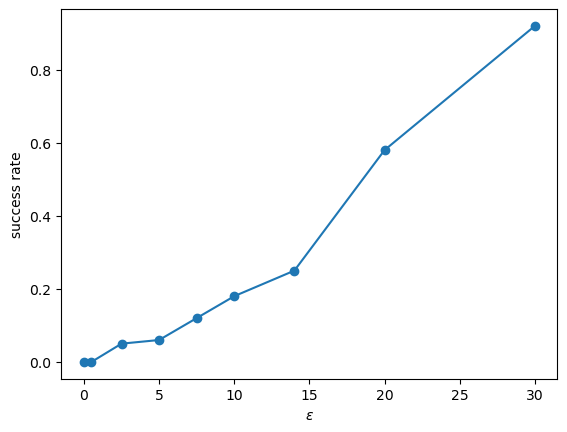

In [10]:
plt.plot(epsilons, success_rate.cpu(), 'o-')
plt.xlabel(r'$\epsilon$')
plt.ylabel('success rate')
plt.show()

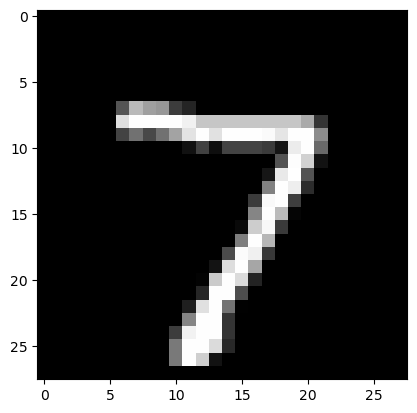

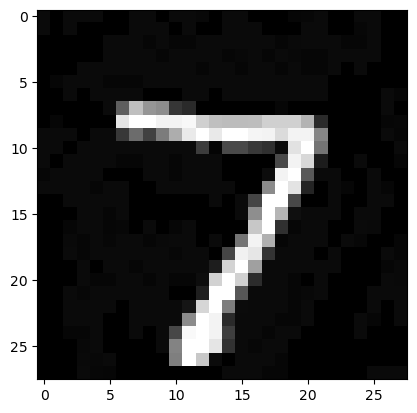

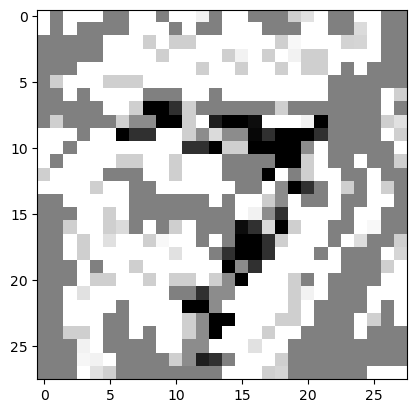

In [45]:
plt.imshow(images[0,0], cmap='gray')
plt.show()

plt.imshow(advs[5][0,0].cpu(), cmap='gray')
plt.show()

plt.imshow(advs[5][0,0].cpu() - images[0,0], cmap='gray')
plt.show()